* https://www.kaggle.com/gmadevs/atp-matches-dataset
* 前回の続き
    * player_strong_bayesian_modeling.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import pystan

In [2]:
cols = [
    'tourney_id', # Id of Tournament
    'tourney_name', # Name of the Tournament
    'surface', # Surface of the Court (Hard, Clay, Grass)
    'draw_size', # Number of people in the tournament
    'tourney_level', # Level of the tournament (A=ATP Tour, D=Davis Cup, G=Grand Slam, M=Masters)
    'tourney_date', # Start date of tournament
    'match_num', # Match number
    'winner_id', # Id of winner
    'winner_seed', # Seed of winner
    'winner_entry', # How the winner entered the tournament
    'winner_name', # Name of winner
    'winner_hand', # Dominant hand of winner (L=Left, R=Right, U=Unknown?)
    'winner_ht', # Height in cm of winner
    'winner_ioc', # Country of winner
    'winner_age', # Age of winner
    'winner_rank', # Rank of winner
    'winner_rank_points', # Rank points of winner
    'loser_id',
    'loser_seed',
    'loser_entry',
    'loser_name',
    'loser_hand',
    'loser_ht',
    'loser_ioc',
    'loser_age',
    'loser_rank',
    'loser_rank_points',
    'score', # Score
    'best_of', # Best of X number of sets
    'round', # Round
    'minutes', # Match length in minutes
    'w_ace', # Number of aces for winner
    'w_df', # Number of double faults for winner
    'w_svpt', # Number of service points played by winner
    'w_1stIn', # Number of first serves in for winner
    'w_1stWon', # Number of first serve points won for winner
    'w_2ndWon', # Number of second serve points won for winner
    'w_SvGms', # Number of service games played by winner
    'w_bpSaved', # Number of break points saved by winner
    'w_bpFaced', # Number of break points faced by winner
    'l_ace',
    'l_df',
    'l_svpt',
    'l_1stIn',
    'l_1stWon',
    'l_2ndWon',
    'l_SvGms',
    'l_bpSaved',
    'l_bpFaced'
]
df_matches = pd.concat([
    pd.read_csv('./data/atp_matches_2000.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2001.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2002.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2003.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2004.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2005.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2006.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2007.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2008.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2009.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2010.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2011.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2012.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2013.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2014.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2015.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2016.csv', usecols=cols),
    pd.read_csv('./data/atp_matches_2017.csv', usecols=cols),
])
df_matches = df_matches.dropna(subset=['tourney_date'])
df_matches['year'] = df_matches['tourney_date'].apply(lambda x: int(str(x)[0:4]))
display(df_matches.head())
print(len(df_matches))

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,year
0,2000-717,Orlando,Clay,32.0,A,20000501.0,1.0,102179.0,NaN,NaN,Antony Dupuis,R,185.0,FRA,27.181383,113.0,351.0,102776.0,1.0,NaN,Andrew Ilie,R,180.0,AUS,24.035592,50.0,762.0,3-6 7-6(6) 7-6(4),3.0,R32,162.0,8.0,1.0,126.0,76.0,56.0,29.0,16.0,14.0,15.0,13.0,4.0,110.0,59.0,49.0,31.0,17.0,4.0,4.0,2000
1,2000-717,Orlando,Clay,32.0,A,20000501.0,2.0,103602.0,NaN,Q,Fernando Gonzalez,R,183.0,CHI,19.756331,352.0,76.0,102821.0,NaN,WC,Cecil Mamiit,R,173.0,PHI,23.843943,139.0,280.0,6-2 7-5,3.0,R32,86.0,4.0,2.0,67.0,35.0,25.0,16.0,10.0,4.0,6.0,0.0,0.0,57.0,24.0,13.0,17.0,10.0,4.0,9.0,2000
2,2000-717,Orlando,Clay,32.0,A,20000501.0,3.0,103387.0,NaN,NaN,Paradorn Srichaphan,R,185.0,THA,20.881588,103.0,380.0,102205.0,NaN,NaN,Sebastien Lareau,R,183.0,CAN,27.011636,133.0,293.0,6-1 6-3,3.0,R32,64.0,4.0,1.0,46.0,29.0,23.0,11.0,8.0,0.0,0.0,2.0,2.0,65.0,39.0,22.0,10.0,8.0,6.0,10.0,2000
3,2000-717,Orlando,Clay,32.0,A,20000501.0,4.0,101733.0,NaN,NaN,Jan Siemerink,L,183.0,NED,30.047912,107.0,371.0,102925.0,8.0,NaN,Justin Gimelstob,R,196.0,USA,23.260780,95.0,408.0,4-6 6-2 7-5,3.0,R32,150.0,8.0,6.0,109.0,56.0,43.0,21.0,15.0,9.0,12.0,4.0,6.0,104.0,57.0,35.0,24.0,15.0,6.0,11.0,2000
4,2000-717,Orlando,Clay,32.0,A,20000501.0,5.0,101727.0,4.0,NaN,Jason Stoltenberg,R,185.0,AUS,30.075291,74.0,543.0,101826.0,NaN,NaN,Alex Lopez Moron,R,175.0,ESP,29.423682,111.0,357.0,6-1 6-4,3.0,R32,60.0,3.0,0.0,50.0,27.0,22.0,16.0,9.0,1.0,1.0,0.0,3.0,47.0,28.0,17.0,10.0,8.0,3.0,6.0,2000


53508


* 選手の潜在的な強さに時系列の要素を入れる
* 各選手の潜在的な強さの時系列モデル
    * 対象選手は、データ数を確認しながら手動で選択
    * 対象期間は、2005〜2017.02頃の戦績
    * 統計モデル
$$
performance[y][g,1]{\sim}Normal(\mu[Loser][y], \sigma_{pf}[Loser][y]), \hspace{1em} g=1{\ldots}G, y=1{\ldots}Y \\
performance[y][g,2]{\sim}Normal(\mu[Winner][y], \sigma_{pf}[Winner][y]), \hspace{1em} g=1{\ldots}G, y=1{\dots}Y \\
performance[y][g,1] < performance[y][g,2], \hspace{1em} g=1{\ldots}G, y=1{\ldots}Y \\
\mu[n][1]{\sim}Normal(0, \sigma_{\mu}[n][1]), \hspace{1em} n=1{\ldots}N \\
\mu[n][y]{\sim}Normal(\mu[n][y-1], \sigma_\mu[n][y-1]), \hspace{1em} n=1{\ldots}N, y=2{\ldots}Y \\
\sigma_{pf}[n][y]{\sim}Gamma(10, 10), \hspace{1em} n=1{\ldots}N, y=1{\ldots}Y \\
\sigma_\mu[n][y]{\sim}Normal(0, 1), \hspace{1em} n=1{\ldots}N, y=1{\ldots}Y \\
$$
        * $Loser$ : 負けたプレイヤーのインデックス
        * $Winner$ : 勝ったプレイヤーのインデックス
        * 各選手の $y$ 年度の強さを $\mu[n][y]$, 勝負ムラを $\sigma_{pf}[n][y]$ とする
        * $y$ 年度に行われる勝負で発揮する力（パフォーマンス）は、平均 $\mu[n][y]$ , 標準偏差 $\sigma_{pf}[n][y]$ の正規分布から生成されると考える
        * 勝負の結果はパフォーマンスの大小で決まる（大きかった方が勝つ）
        * 各選手のある年度での強さは、その1つ前の年度の強さから生成されると考える
        * 各選手の年度別の強さの変化具合 $\sigma_\mu[n][y]$ は半正規分布に従う
        * 各選手の初年度の強さは平均 $0$ , 標準偏差 $\sigma_{\mu}[n][1]$ の半正規分布に従う

In [3]:
arr_target_year = np.array(list(range(2005, 2017)))
arr_target_year

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

In [4]:
arr_target_player = np.array([
    'Roger Federer',
    'Rafael Nadal',
    'Novak Djokovic',
    'Andy Murray',
    'Stanislas Wawrinka',
    'Juan Martin Del Potro',
    #'Milos Raonic',
    'Kei Nishikori',
    #'Gael Monfils',
    'Tomas Berdych',
    #'Jo Wilfried Tsonga',
    'David Ferrer',
    #'Richard Gasquet',
    #'Marin Cilic',
    #'Grigor Dimitrov',
    #'Dominic Thiem',
    #'Nick Kyrgios',
    #'Alexander Zverev'
])
arr_target_player

array(['Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Andy Murray',
       'Stanislas Wawrinka', 'Juan Martin Del Potro', 'Kei Nishikori',
       'Tomas Berdych', 'David Ferrer'], dtype='<U21')

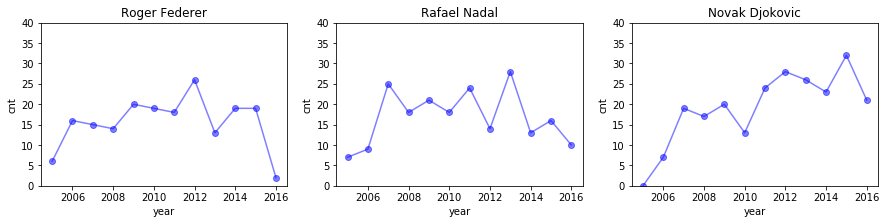

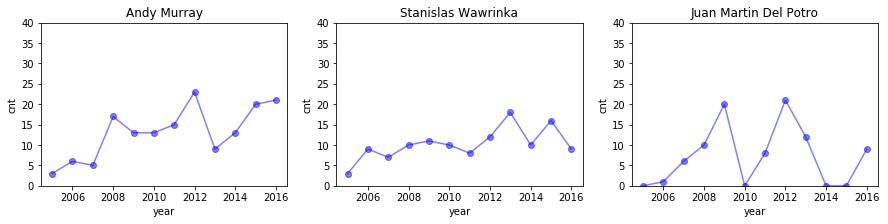

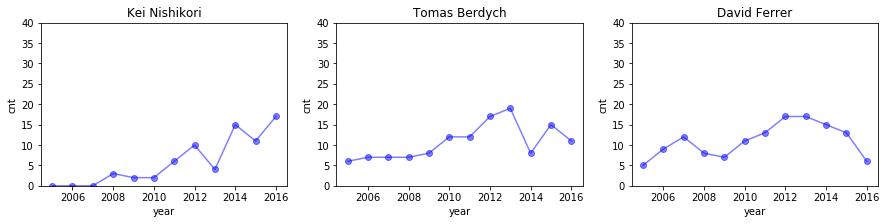

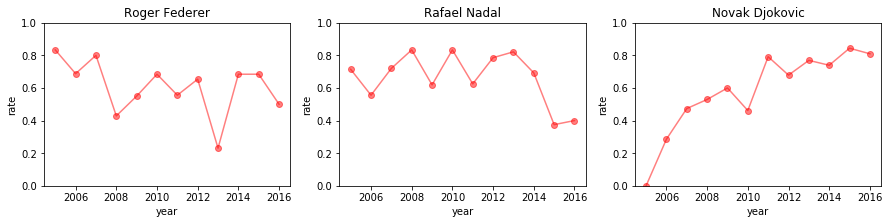

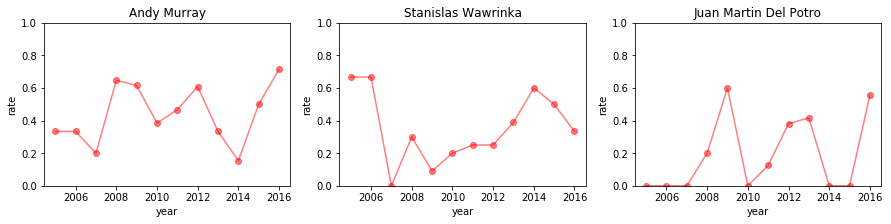

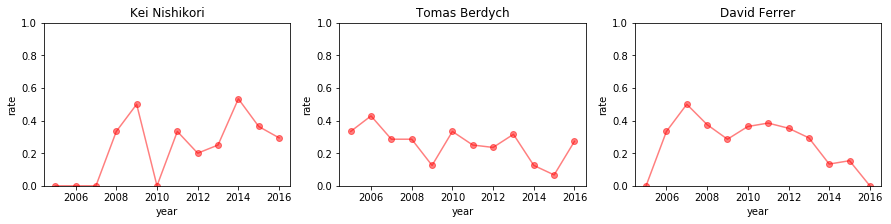

In [5]:
df_tmp = df_matches[
    (df_matches['winner_name'].isin(arr_target_player)) &
    (df_matches['loser_name'].isin(arr_target_player))
]

matrix_cnt = np.zeros((len(arr_target_year), len(arr_target_player)), dtype=np.float32)
matrix_rate = np.zeros((len(arr_target_year), len(arr_target_player)), dtype=np.float32)

for i, year in enumerate(arr_target_year):
    
    for j, player in enumerate(arr_target_player):
        
        cnt_win = len(df_tmp[(df_tmp['winner_name'] == player) & (df_tmp['year'] == year)])
        cnt_lose = len(df_tmp[(df_tmp['loser_name'] == player) & (df_tmp['year'] == year)])
        
        rate = 0 if (cnt_win+cnt_lose == 0) else cnt_win/(cnt_win+cnt_lose)
        
        matrix_cnt[i, j] = cnt_win+cnt_lose
        matrix_rate[i, j] = rate

for j, player in enumerate(arr_target_player):
    
    if j % 3 == 0:
            
        fig, axs = plt.subplots(ncols=3, figsize=(15, 3))

    axs[j%3].plot(arr_target_year, matrix_cnt[:, j], marker='o', color='b', alpha=0.5)
    axs[j%3].set(title=player, xlabel='year', ylabel='cnt', ylim=[0, 40])

plt.show()

for j, player in enumerate(arr_target_player):
    
    if j % 3 == 0:
            
        fig, axs = plt.subplots(ncols=3, figsize=(15, 3))

    axs[j%3].plot(arr_target_year, matrix_rate[:, j], marker='o', color='r', alpha=0.5)
    axs[j%3].set(title=player, xlabel='year', ylabel='rate', ylim=[0, 1])

plt.show()

In [6]:
dic_target_year = {}

for year in arr_target_year:
    
    if year not in dic_target_year:
        
        dic_target_year[year] = len(dic_target_year)+1
        
dic_target_year

{2005: 1,
 2006: 2,
 2007: 3,
 2008: 4,
 2009: 5,
 2010: 6,
 2011: 7,
 2012: 8,
 2013: 9,
 2014: 10,
 2015: 11,
 2016: 12}

In [7]:
dic_target_player = {}

for player in arr_target_player:
    
    if player not in dic_target_player:
        
        dic_target_player[player] = len(dic_target_player)+1
        
dic_target_player

{'Andy Murray': 4,
 'David Ferrer': 9,
 'Juan Martin Del Potro': 6,
 'Kei Nishikori': 7,
 'Novak Djokovic': 3,
 'Rafael Nadal': 2,
 'Roger Federer': 1,
 'Stanislas Wawrinka': 5,
 'Tomas Berdych': 8}

In [8]:
LW = []
GY = []

for year in arr_target_year:
    for player_a in arr_target_player:
        for player_b in arr_target_player:
        
            df_tmp = df_matches[
                (df_matches['year'] == year) &
                (df_matches['winner_name'] == player_a) &
                (df_matches['loser_name'] == player_b)
            ]
        
            for _ in range(len(df_tmp)):
            
                LW.append([dic_target_player[player_b], dic_target_player[player_a]])
                GY.append(dic_target_year[year])
            
            df_tmp = df_matches[
                (df_matches['year'] == year) &
                (df_matches['winner_name'] == player_b) &
                (df_matches['loser_name'] == player_a)
            ]
        
            for _ in range(len(df_tmp)):
            
                LW.append([dic_target_player[player_a], dic_target_player[player_b]])
                GY.append(dic_target_year[year])

LW = np.array(LW, dtype=np.int32)
GY = np.array(GY, dtype=np.int32)
LW, GY

(array([[2, 1],
        [1, 2],
        [4, 1],
        ...,
        [9, 6],
        [9, 8],
        [9, 8]], dtype=int32),
 array([ 1,  1,  1, ..., 12, 12, 12], dtype=int32))

In [9]:
model = """
    data {
        int N;
        int G;
        int Y;
        int<lower=1> GY[G];
        int<lower=1, upper=N> LW[G, 2];
    }
    parameters {
        ordered[2] performance[G];
        matrix<lower=0>[N, Y] mu;
        matrix<lower=0>[N, Y] s_mu;
        matrix<lower=0>[N, Y] s_pf;
    }
    model {
        for (g in 1:G)
            for (i in 1:2)
                performance[g, i] ~ normal(mu[LW[g, i], GY[g]], s_pf[LW[g, i], GY[g]]);
        
        for (n in 1:N)
            mu[n, 1] ~ normal(0, s_mu[n, 1]);
            
        for (n in 1:N)
            for (y in 2:Y)
                mu[n, y] ~ normal(mu[n, y-1], s_mu[n, y]);
           
        for (n in 1:N)
            s_mu[n] ~ normal(0, 1);
        
        for (n in 1:N)
            s_pf[n] ~ gamma(10, 10);
    }
"""
data = {
    'N': len(dic_target_player),
    'G': len(LW),
    'Y': len(dic_target_year),
    'GY': GY,
    'LW': LW,
}
fit2 = pystan.stan(model_code=model, data=data, iter=5000, chains=4)
la2 = fit2.extract()
fit2

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3c1718846b89aba379205c16add9d7f3 NOW.


Inference for Stan model: anon_model_3c1718846b89aba379205c16add9d7f3.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
performance[0,0]      1.49    0.07   1.11  -0.84   0.82   1.53   2.21   3.91    273   1.02
performance[1,0]      1.65    0.03   1.02  -0.51   1.08   1.68    2.3   3.52   1111    1.0
performance[2,0]      0.41    0.02   0.99  -1.71  -0.17   0.46   1.04    2.3   2433    1.0
performance[3,0]      0.93    0.03   1.01  -1.12   0.26   0.98   1.59   2.88   1374    1.0
performance[4,0]      0.43    0.04    1.1  -2.01  -0.21   0.47   1.16   2.38    775    1.0
performance[5,0]      0.17    0.02    0.9  -1.69  -0.42    0.2   0.79   1.85   2017    1.0
performance[6,0]       1.7    0.04    1.0   -0.4   1.07   1.73   2.43    3.5    654    1.0
performance[7,0]      1.45    0.06    1.1  -0.87   0.81   1.49    2.1   3.68    34

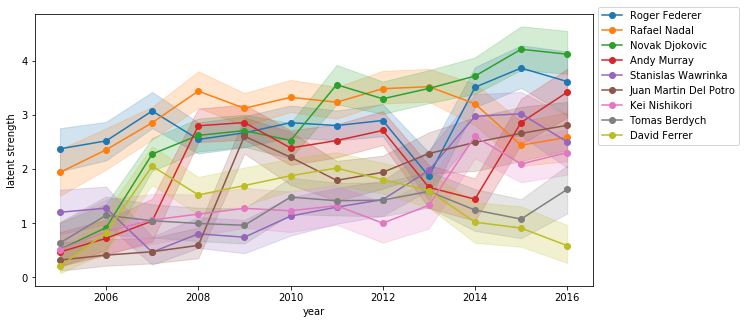

In [10]:
plt.figure(figsize=(10,5))
cmap = matplotlib.cm.get_cmap('tab10')

for j, player in enumerate(arr_target_player):

    samples = la2['mu'][:, j, :]
    
    medians = np.median(samples, axis=0)
    lower, upper = np.percentile(samples, q=[25.0, 75.0], axis=0)
    
    c = cmap(j)
    
    plt.plot(arr_target_year, medians, marker='o', label=player, color=c)
    plt.fill_between(arr_target_year, lower, upper, alpha=0.2, color=c)
    
plt.xlabel('year')
plt.ylabel('latent strength')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.show()

* 2005年頃は、フェデラー、ナダルの２強時代の様子がよくわかる
* 2008年頃から、フェデラー、ナダルに迫る若手、ジョコビッチ、マレー、デル・ポトロなどの強さの推移がわかる
* 錦織は2014年に強さが急激に上昇（ちなみにこの年に初めて世界ランクTOP10入り）
* デル・ポトロは2009年（初めてグランドスラムに優勝した年）に急激に上昇するも、怪我の影響で推移を落としている様子が見れる
* マレーは2008年頃からフェデラー、ナダルに勝つようになったが、2014年に怪我で不調となっている様子がはっきりと現れた
* フェレール、ベルディヒは停滞している

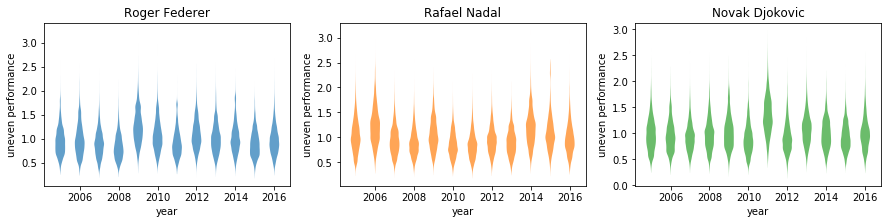

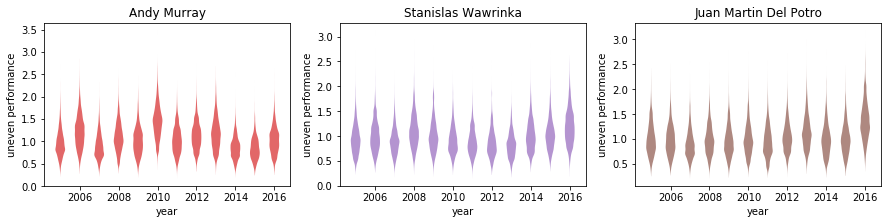

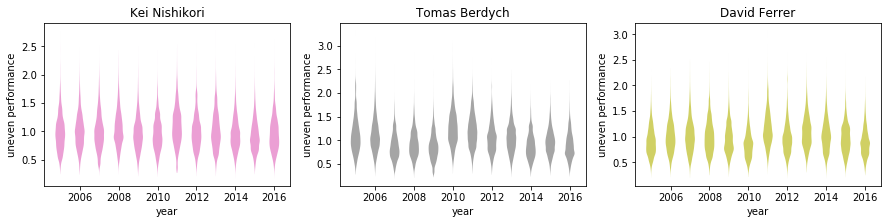

In [11]:
cmap = matplotlib.cm.get_cmap('tab10')

for j, player in enumerate(arr_target_player):
    
    if j % 3 == 0:
            
        fig, axs = plt.subplots(ncols=3, figsize=(15, 3))
        
    g = axs[j%3].violinplot(la2['s_pf'][:, j, :], positions=arr_target_year, showmeans=False, showextrema=False, showmedians=False)
    c = cmap(j%10)
    
    for pc in g['bodies']:
        
        pc.set_facecolor(c)
        pc.set_alpha(0.7)
        
    axs[j%3].set(title=player, xlabel='year', ylabel='uneven performance')
    
plt.show()

* マレーが、年によって勝負ムラが大きくなるような結果
* ワウリンカは、直近（2015〜2017.02）は勝負ムラが大きかったものの、それまでの年で言えば、比較的大きくなかった模様
* 錦織は、直近（2015〜2017.02）の分析と同様、勝負ムラはあまり大きくない傾向にあり、勝つ相手には勝つ、負ける相手には負けるがハッキリしている様子

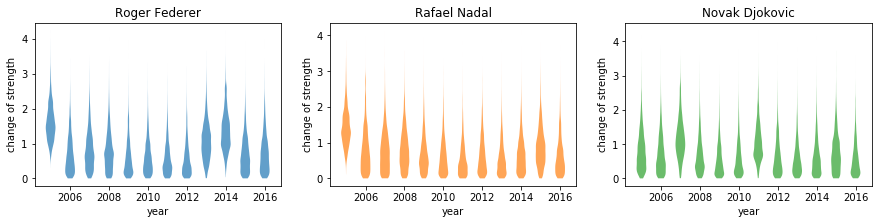

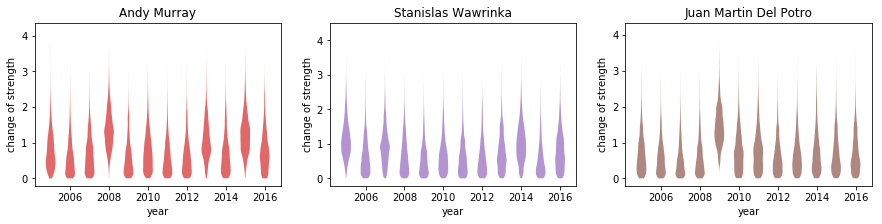

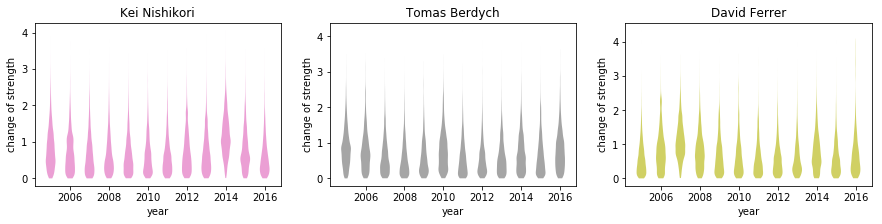

In [13]:
cmap = matplotlib.cm.get_cmap('tab10')

for j, player in enumerate(arr_target_player):
    
    if j % 3 == 0:
            
        fig, axs = plt.subplots(ncols=3, figsize=(15, 3))
        
    g = axs[j%3].violinplot(la2['s_mu'][:, j, :], positions=arr_target_year, showmeans=False, showextrema=False, showmedians=False)
    c = cmap(j%10)
    
    for pc in g['bodies']:
        
        pc.set_facecolor(c)
        pc.set_alpha(0.7)
        
    axs[j%3].set(title=player, xlabel='year', ylabel='change of strength')
    
plt.show()

* 基本的には、強さの時系列のモデルの傾きと、大きさが連動している
* 初年度は 0 から推定させていることもあり、元から強かったフェデラー、ナダルがいきなり強くなっているように見える
* マレーは、フェデラー、ナダルに勝つようになった上向きの強さの変化と、不調による下向きの強さの変化が見える
* デル・ポトロは、2009年で強さが大きく変化していることがわかる
* 錦織は、2014年で強さが大きく変化していることがわかる

In [14]:
!python --version

Python 3.6.6 :: Anaconda custom (64-bit)


In [15]:
!pip freeze

absl-py==0.2.2
alabaster==0.7.10
algopy==0.5.7
altair==2.1.0
anaconda-client==1.6.5
anaconda-navigator==1.6.9
anaconda-project==0.8.0
annoy==1.12.0
appdirs==1.4.3
arrow==0.12.1
asn1crypto==0.22.0
astor==0.7.1
astroid==1.5.3
astropy==2.0.2
attrs==18.1.0
audioread==2.1.6
Babel==2.5.0
backports.shutil-get-terminal-size==1.0.0
Baker==1.3
basemap==1.1.0
bayesian-optimization==0.6.0
bayespy==0.5.17
bcolz==1.2.1
beautifulsoup4==4.6.0
biopython==1.72
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==1.5.0
blist==1.3.6
bokeh==0.13.0
Boruta==0.1.5
boto==2.48.0
boto3==1.7.54
botocore==1.10.54
Bottleneck==1.2.1
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
branca==0.3.0
bz2file==0.98
cachetools==2.1.0
cairocffi==0.8.1
CairoSVG==2.1.3
Cartopy==0.16.0
catboost==0.9.1.1
category-encoders==1.2.8
certifi==2018.4.16
cffi==1.10.0
chainer==4.2.0
chardet==3.0.4
click==6.7
click-plugins==1.0.3
cligj==0.4.0
cloudpickle==0.4.0
clyent==1.2.2
cmudi